In [1]:
%%system
rm /scratch/ors -r
mkdir /scratch/ors
mkdir /scratch/ors/dmg
cp ~/ors-project/data.tar.gz /scratch/ors
tar -xzvf /scratch/ors/data.tar.gz --directory /scratch/ors/
mv /scratch/ors/patches_256_v2/ /scratch/ors/clr

["rm: cannot remove '/scratch/ors': No such file or directory",
 'patches_256_v2/',
 'patches_256_v2/47241882b3ec18350d5cf9f2b2ae7126.png',
 'patches_256_v2/f3bc77c7c77490d57feb757311ec78d0.png',
 'patches_256_v2/853c1077ca1750b4a4f13fc5bf49c0d1.png',
 'patches_256_v2/271b8741f4669704c795e04c8dc054b9.png',
 'patches_256_v2/33e98642af577a500dffd3936629ebe7.png',
 'patches_256_v2/44a924d539458dd0c490340ab9a611c4.png',
 'patches_256_v2/271b38b5c8419709160b5365bee967a5.png',
 'patches_256_v2/8d899ea6c7ccc62206e4243b8ab40fbe.png',
 'patches_256_v2/ecf50e585ecbe7a69a26807143e56c4c.png',
 'patches_256_v2/4f770737e533fefeb5e02d8010dbfad4.png',
 'patches_256_v2/dba15f7ceea4841b2ec46045d6d6b71c.png',
 'patches_256_v2/5fb27c8713f6c4d03814ac853ff47acf.png',
 'patches_256_v2/77a70f7a45892ec3cfb60138621567ee.png',
 'patches_256_v2/23a476f783cc6effd207ae81926dd8f2.png',
 'patches_256_v2/4c061e4b40febe21e4e70b6b7f861790.png',
 'patches_256_v2/b366346cb994faf4e6a562dab306cf02.png',
 'patches_256_v2/c71

In [2]:
from fastai.vision.all import *
from PIL import Image, ImageDraw
from random import randint

In [352]:
import wandb
wandb.init(project="ors_project", entity="android100")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: android100 (use `wandb login --relogin` to force relogin)


In [339]:
from fastai.callback.wandb import *

In [340]:
path = Path("/scratch/ors/")
path_clear = path/"clr"
path_damaged = path/"dmg"

In [368]:
LINE_WIDTH = 2
STRIP_IMAGE_SIZE = 512

In [347]:
stripes_base = Image.new("RGBA", (STRIP_IMAGE_SIZE, STRIP_IMAGE_SIZE), (255, 255, 255, 0))
stripes = ImageDraw.Draw(stripes_base)
for y in range(int(1.1 * LINE_WIDTH), int(STRIP_IMAGE_SIZE - 0.1 * LINE_WIDTH), 20):
    stripes.line([0, y, STRIP_IMAGE_SIZE, y], width=LINE_WIDTH, fill="BLACK")

def damage_image(image_path):    
    img = Image.open(image_path)
    damage_lines = stripes_base.rotate(random.randint(0, 360))
    damage_lines = damage_lines.crop(((STRIP_IMAGE_SIZE - 256)/2, (STRIP_IMAGE_SIZE - 256)/2, (STRIP_IMAGE_SIZE + 256)/2, (STRIP_IMAGE_SIZE + 256)/2, ))
    img.paste(damage_lines, (0, 0), damage_lines)
    img.save(path_damaged/image_path.name)

In [351]:
parallel(damage_image, path_clear.ls(), n_workers=8, progress=True)

(#12900) [None,None,None,None,None,None,None,None,None,None...]

In [354]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                  get_items=get_image_files,
                  get_y=lambda x: path_clear/x.name,
                  splitter=RandomSplitter(),
                  item_tfms=Resize(224),
                  batch_tfms=[*aug_transforms(max_zoom=2.),
                             Normalize.from_stats(*imagenet_stats)])

In [355]:
dls = dblock.dataloaders(path_damaged, bs=8)

/home2/s.ranjan/miniconda3/envs/ors/lib/python3.6/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [356]:
dls_gen = dls
dls_gen.c = 3

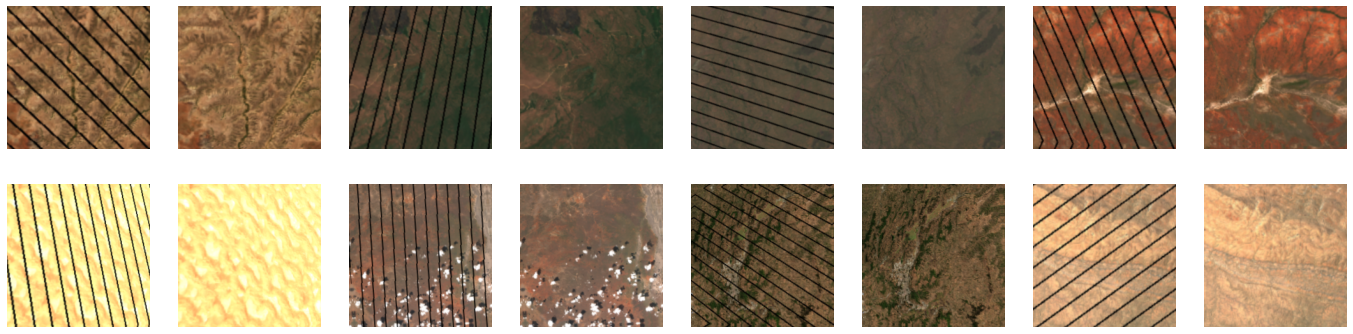

In [357]:
dls_gen.show_batch()

In [358]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()

In [359]:
bbone = resnet34
# cfg = unet_config(blur=True, norm_type=NormType.Weight, self_attention=True,
#                   y_range=y_range)

In [360]:
def create_gen_learner():
    return unet_learner(dls_gen, bbone, loss_func=loss_gen, cbs=WandbCallback())

In [361]:
learn_gen = create_gen_learner()

In [362]:
learn_gen.fit_one_cycle(5, pct_start=0.8, wd=wd)

WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,time
0,0.017452,0.026227,04:00
1,0.008460,0.010576,04:21
2,0.006538,0.008601,04:16
3,0.005662,0.006885,04:18
4,0.003818,0.005946,04:10


In [363]:
learn_gen.unfreeze()

In [364]:
learn_gen.fit_one_cycle(2, slice(1e-6,1e-3), wd=wd)

epoch,train_loss,valid_loss,time
0,0.004468,0.005235,04:31
1,0.003488,0.005631,04:31


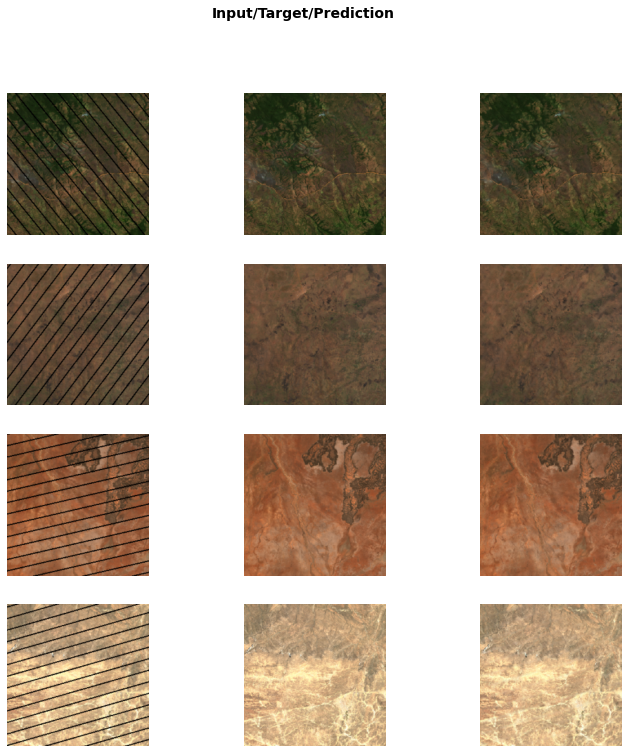

In [365]:
learn_gen.show_results(max_n=4, figsize=(12,12))

In [366]:
learn_gen.save('image_restoration_striped_lines')

Path('models/image_restoration_striped_lines.pth')

In [367]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇█████▇▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇█████▇▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁
lr_2,▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇█████▇▅▃▂▁▃▇██▇▆▅▄▂▁▁
mom_0,████▇▇▇▆▆▆▅▅▄▃▃▃▂▂▂▁▁▁▁▁▂▄▆▇█▆▂▁▁▂▃▄▅▇██
mom_1,████▇▇▇▆▆▆▅▅▄▃▃▃▂▂▂▁▁▁▁▁▂▄▆▇█▆▂▁▁▂▃▄▅▇██
mom_2,████▇▇▇▆▆▆▅▅▄▃▃▃▂▂▂▁▁▁▁▁▂▄▆▇█▆▂▁▁▂▃▄▅▇██
raw_loss,█▇▄▃▂▂▁▁▂▂▁▂▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
